In [178]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance, plot_tree
import os, sys
from collections import defaultdict
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, plot_roc_curve,plot_confusion_matrix
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import scipy

In [2]:
!git clone https://github.com/avidutta20/challenge_may21

Cloning into 'challenge_may21'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 61 (delta 25), reused 26 (delta 6), pack-reused 0
Unpacking objects: 100% (61/61), done.


In [3]:
os.chdir('/content/challenge_may21/')

In [85]:
def load_data():
    pass
df = pd.read_csv('dataset/av_jobathon_may21_train.csv')

# creating a list of all trainable features name
feature_list = df.columns[1:10]
target = df.columns[10]  # 'Is_Lead' column name

# splitting into train & test
x_train, x_test, y_train, y_test = train_test_split(df[feature_list], df[target], test_size=0.25, random_state=25)


In [5]:
def get_raw_train_data(with_labels = False):
  # splitting into train & test
  x_train, x_test, y_train, y_test = train_test_split(df[feature_list], df[target], test_size=0.25, random_state=25)
    
  if with_labels:
    x_train['Is_Lead'] = y_train

  return x_train

In [6]:
# creating a x_train_complete x_train_df copy
x_train_df = x_train.copy()
x_train_df['Is_Lead'] = y_train

# creating a x_train processing_experimenting copy
x_train_raw = x_train_df.copy()

#Data Processing

In [7]:
def checking_dataset_balance(df,feature_name, target):
  
  class_labels = df[target].unique()
  total_rows = df[target].count()
  class_dict={}
  for label in class_labels:
    class_dict[label] = {'value': df[target].loc[df[target]==label].count()}
    class_dict[label]['perc'] = (df[target].loc[df[target]==label].count())/total_rows
  return class_dict

# checking dataset imbalance
checking_dataset_balance(df,feature_list,target)

# dataset is not imbalanced.

{0: {'perc': 0.7627917387323228, 'value': 187437},
 1: {'perc': 0.23720826126767727, 'value': 58288}}

## Processing Catagorical Values

In [8]:
def execute_process(dframe, colname,func,arg1):
    colname_new = colname + '_proc'
    dframe[colname_new] = dframe[colname].apply(lambda x: func(x,arg1))
    return dframe
def extract_process(value,index):
    value = int(value[index:])
    return value

def replace_values(value, value_dic):
    # replaces any value in the dframe colname with given dict
    return value_dic[value]

def default_value():
    return 0

def one_hot(dframe, colname):
  onehotencoder = OneHotEncoder()
  #reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
  X = onehotencoder.fit_transform(dframe[colname].values.reshape(-1,1)).toarray()
  # creating a dataframe 
  dfOneHotx = pd.DataFrame(X, columns = [colname+"_"+str(int(i)) for i in range(len(dframe[colname].unique()))])
  # adding index to the dataframe as dframe for joining
  dfOneHotx.set_index(dframe.index, inplace=True)
  # concatinating the two
  df2 = pd.concat([dframe, dfOneHotx], axis = 1)
  
  return df2

In [9]:
def process(dframe, default_func = default_value):
  gender_dic = is_active_dic = occupation_dic = defaultdict(default_value)


  gender_dic = is_active_dic = occupation_dic = defaultdict(default_value)
  
  gender_dic = {'Male': 0,
                  'Female': 1}
  is_active_dic = {'Yes': 1,
                  'No': 0}

  occupation_dic = {'Self_Employed': 1,
                      'Other': 2,
                      'Salaried': 3,
                      'Entrepreneur': 4}

  execute_process(dframe,'Region_Code', extract_process, 2)
  print('Region Code Processed Successfully')

  execute_process(dframe,'Channel_Code', extract_process, 1)
  print('Channel Code Processed Successfully')
  dframe = one_hot(dframe, 'Channel_Code_proc')

  dframe = execute_process(dframe,'Gender', replace_values, gender_dic)
  print('Gender Processed Successfully')
  dframe = one_hot(dframe, 'Gender_proc')

  execute_process(dframe,'Occupation', replace_values, occupation_dic)
  print('Occupation Processed Successfully')
  dframe = one_hot(dframe, 'Occupation_proc')

  execute_process(dframe,'Is_Active',replace_values, is_active_dic)
  print('Is Active Processed Successfully')
  dframe = one_hot(dframe, 'Is_Active_proc')

  dframe['Credit_Product'] = dframe['Credit_Product'].fillna('No')
  execute_process(dframe,'Credit_Product',replace_values, is_active_dic)
  dframe = one_hot(dframe, 'Credit_Product_proc')
  return dframe

## Cheking SkewNess

In [16]:
# # checking skewness
# scipy.stats.skew(x_train_df['Avg_Account_Balance'])

In [17]:
x_train_df = get_raw_train_data(with_labels=True)

In [18]:
# processing x_train_df
x_train_df = process(x_train_df)

Region Code Processed Successfully
Channel Code Processed Successfully
Gender Processed Successfully
Occupation Processed Successfully
Is Active Processed Successfully


In [19]:
x_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184293 entries, 188708 to 29828
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Gender                 184293 non-null  object 
 1   Age                    184293 non-null  int64  
 2   Region_Code            184293 non-null  object 
 3   Occupation             184293 non-null  object 
 4   Channel_Code           184293 non-null  object 
 5   Vintage                184293 non-null  int64  
 6   Credit_Product         184293 non-null  object 
 7   Avg_Account_Balance    184293 non-null  int64  
 8   Is_Active              184293 non-null  object 
 9   Is_Lead                184293 non-null  int64  
 10  Region_Code_proc       184293 non-null  int64  
 11  Channel_Code_proc      184293 non-null  int64  
 12  Channel_Code_proc_0    184293 non-null  float64
 13  Channel_Code_proc_1    184293 non-null  float64
 14  Channel_Code_proc_2    184293 no

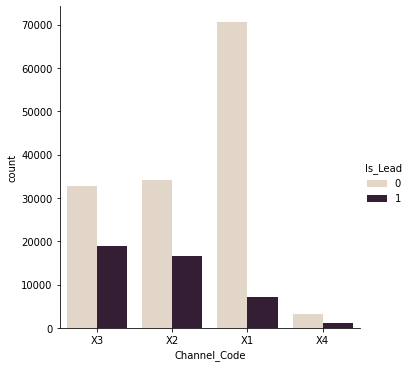

In [20]:
sns.catplot(x='Channel_Code', hue = 'Is_Lead', kind="count", palette="ch:.25", data=x_train_df)

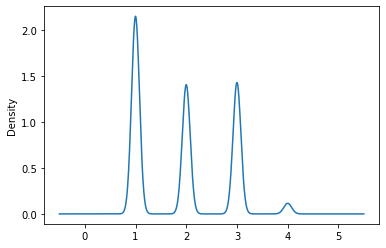

In [21]:
x_train_df['Channel_Code_proc'].plot.kde()

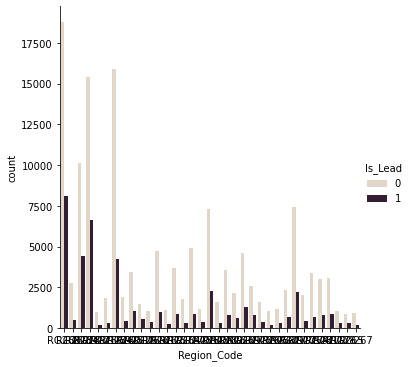

In [22]:
sns.catplot(x='Region_Code', hue = 'Is_Lead', kind="count", palette="ch:.25", data=x_train_df)

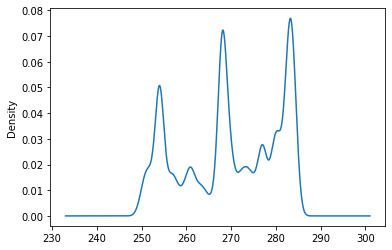

In [23]:
x_train_df['Region_Code_proc'].plot.kde()

In [ ]:
# Checking Integral datas
# columns are:Age, Vintage, Account_Balance

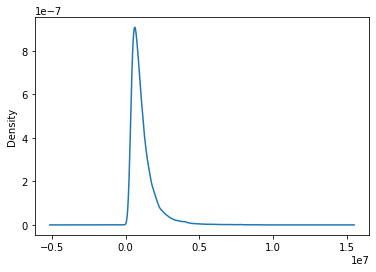

In [24]:
x_train_df['Avg_Account_Balance'].plot.kde()

In [25]:
# the graph shows the average balance is highly right skewed.
# calculating skewness
skew_ac_bal = scipy.stats.skew(x_train_df['Avg_Account_Balance'])
# a +ve high value as expected
skew_ac_bal

2.9757408570525747

## log transform

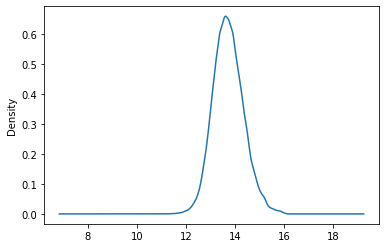

In [10]:
# let's log transform it reduce to reduce it's skewness
#log_transforming
def log_transform(x):
  result = 0.0
  if x!=0:
    result = np.log(x)
  else:
    result = np.log(0.00001)
  return result

x_train_df['Avg_Account_Balance_log'] = x_train_df['Avg_Account_Balance'].apply(lambda x: log_transform(x))
x_train_df['Avg_Account_Balance_log'].plot.kde()

In [27]:
# checking new skew
skew_ac_bal_log = scipy.stats.skew(x_train_df['Avg_Account_Balance_log'])
print(f'Skew after applying log_transform to "Avg_Account_Balance_log is {skew_ac_bal_log}"')
# which is less than +0.5 showing a good normal curve as we wanted

Skew after applying log_transform to "Avg_Account_Balance_log is 0.23654555482098255"


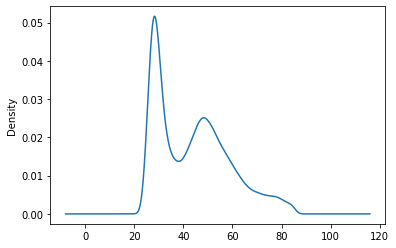

In [28]:
# Age
x_train_df['Age'].plot.kde()

In [11]:
# the graph shows the age is also not normal.
# based on inspecting we will break the age into three groups based on the local minimas in graph
# 0-20, 20-40,40-60, 60 and up
def bin_age(x):
  # catagories = ['0-20','20-40','40-60','60+']
  cat = ''
  
  if x>20 and x<=40:
    cat = '20-40'
  elif x>40 and x<=60:
    cat = '40-60'
  elif x>60 :
    cat = '60+'
  else :
    cat = '0-20'
  return cat

In [30]:
x_train_df['Age_Binned'] = x_train_df['Age'].apply(lambda x: bin_age(x))
x_train_df

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Region_Code_proc,Channel_Code_proc,Channel_Code_proc_0,Channel_Code_proc_1,Channel_Code_proc_2,Channel_Code_proc_3,Gender_proc,Gender_proc_0,Gender_proc_1,Occupation_proc,Occupation_proc_0,Occupation_proc_1,Occupation_proc_2,Occupation_proc_3,Is_Active_proc,Is_Active_proc_0,Is_Active_proc_1,Credit_Product_proc,Credit_Product_proc_0,Credit_Product_proc_1,Avg_Account_Balance_log,Age_Binned
188708,Male,44,RG268,Self_Employed,X3,87,No,543460,No,0,268,3,0.0,0.0,1.0,0.0,0,1.0,0.0,1,1.0,0.0,0.0,0.0,0,1.0,0.0,0,1.0,0.0,13.205711,40-60
17007,Female,50,RG252,Self_Employed,X2,69,No,891895,Yes,0,252,2,0.0,1.0,0.0,0.0,1,0.0,1.0,1,1.0,0.0,0.0,0.0,1,0.0,1.0,0,1.0,0.0,13.701104,40-60
109929,Male,77,RG284,Other,X3,81,No,1163416,No,0,284,3,0.0,0.0,1.0,0.0,0,1.0,0.0,2,0.0,1.0,0.0,0.0,0,1.0,0.0,0,1.0,0.0,13.966871,60+
81455,Male,74,RG283,Other,X1,14,No,1720031,No,0,283,1,1.0,0.0,0.0,0.0,0,1.0,0.0,2,0.0,1.0,0.0,0.0,0,1.0,0.0,0,1.0,0.0,14.357853,60+
77866,Female,25,RG283,Other,X1,21,No,1489690,Yes,0,283,1,1.0,0.0,0.0,0.0,1,0.0,1.0,2,0.0,1.0,0.0,0.0,1,0.0,1.0,0,1.0,0.0,14.214079,20-40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130365,Female,68,RG254,Other,X3,93,No,2039817,Yes,0,254,3,0.0,0.0,1.0,0.0,1,0.0,1.0,2,0.0,1.0,0.0,0.0,1,0.0,1.0,0,1.0,0.0,14.528371,60+
92303,Female,34,RG284,Salaried,X1,20,No,873268,Yes,0,284,1,1.0,0.0,0.0,0.0,1,0.0,1.0,3,0.0,0.0,1.0,0.0,1,0.0,1.0,0,1.0,0.0,13.679998,20-40
6618,Male,28,RG253,Other,X1,26,No,1186040,Yes,0,253,1,1.0,0.0,0.0,0.0,0,1.0,0.0,2,0.0,1.0,0.0,0.0,1,0.0,1.0,0,1.0,0.0,13.986131,20-40
90430,Female,50,RG284,Salaried,X2,55,No,1649000,Yes,1,284,2,0.0,1.0,0.0,0.0,1,0.0,1.0,3,0.0,0.0,1.0,0.0,1,0.0,1.0,0,1.0,0.0,14.315680,40-60


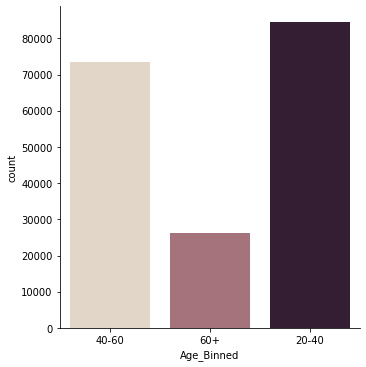

In [31]:
sns.catplot(x='Age_Binned', kind="count", palette="ch:.25", data=x_train_df)

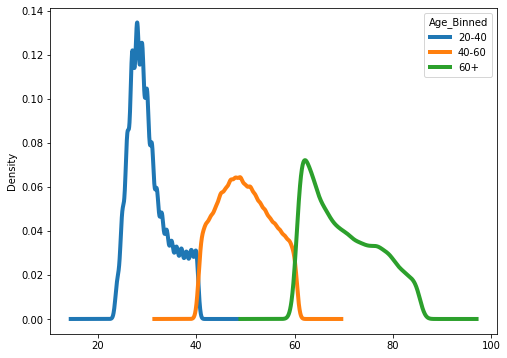

In [32]:
# Converting to wide dataframe
data_wide = x_train_df.pivot(columns = 'Age_Binned',
                     values = 'Age')
  
# plotting multiple density plot
data_wide.plot.kde(figsize = (8, 6),
                   linewidth = 4)

## age next transform

In [ ]:
# We see that the graph are normal in their group

In [12]:
# x_train['Age_log'] = x_train['Age'].apply(lambda x: log_transform(np.exp(x)))
# x_train['Age_Binned_log'] = x_train['Age_log'].apply(lambda x: bin_age(x))
# using box_cox transform
# transform training data & save lambda value
x_train_df['Age_box'], fitted_lambda = scipy.stats.boxcox(x_train_df['Age'])

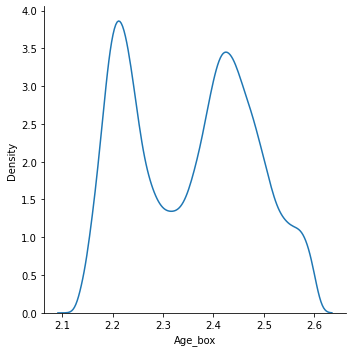

In [13]:
sns.displot(x='Age_box',kind='kde',data=x_train_df)

In [ ]:
# # Converting to wide dataframe
# data_wide = x_train_df.pivot(columns = 'Age_Binned_log',
#                      values = 'Age_box')
  
# # plotting multiple density plot
# data_wide.plot.kde(figsize = (8, 6),
#                    linewidth = 4)

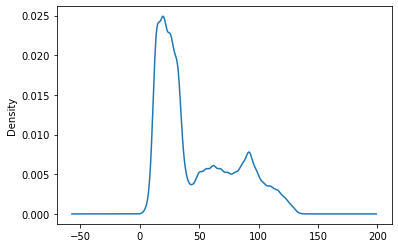

In [14]:
# Vintage
x_train_df['Vintage'].plot.kde()

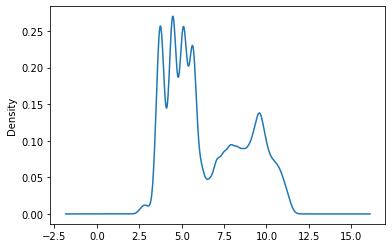

In [ ]:
x_train_df['Vintage_sqrt'] = x_train_df['Vintage'].apply(lambda x: np.sqrt(x))
x_train_df['Vintage_sqrt'].plot.kde()

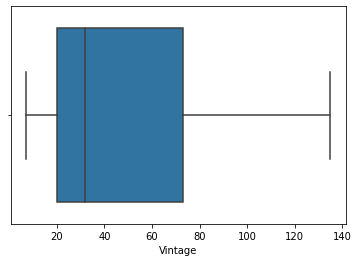

In [ ]:
sns.boxplot(x='Vintage',data=x_train_df)

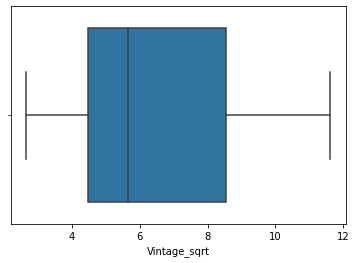

In [ ]:
sns.boxplot(x='Vintage_sqrt',data=x_train_df)

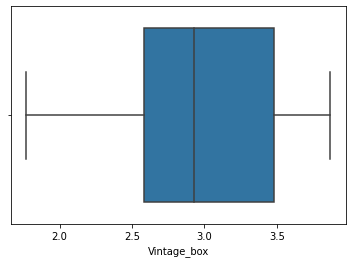

In [ ]:
x_train_df['Vintage_box'], fitted_lambda = scipy.stats.boxcox(x_train_df['Vintage'])
sns.boxplot(x='Vintage_box',data=x_train_df)

In [ ]:
x_train['Vintage']

188708    87
17007     69
109929    81
81455     14
77866     21
          ..
130365    93
92303     20
6618      26
90430     55
29828     25
Name: Vintage, Length: 184293, dtype: int64

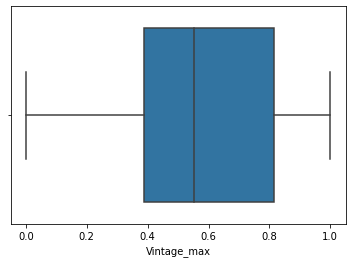

In [ ]:
normalize = MinMaxScaler()
array = np.asanyarray(x_train_df['Vintage_box'])
array = array.reshape(-1,1)

array_norm = normalize.fit_transform(array)

std_scaler = StandardScaler()
array_std = std_scaler.fit_transform(array_norm)

# applying both the functions
x_train_df['Vintage_max'] = array_norm
# x_train['Vintage_std'] = array_std

sns.boxplot(x='Vintage_max',data=x_train_df)


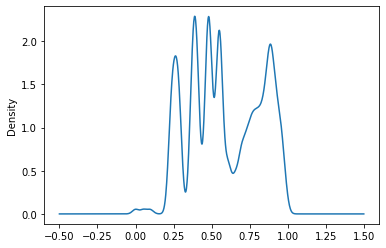

In [ ]:
x_train_df['Vintage_max'].plot.kde()

In [ ]:
# reshaping the column to apply minmax scaler
array = np.asanyarray(x_train_df['Age_Binned'])
array = array.reshape(-1,1)

# normalizing using minmax scaler
enc = OneHotEncoder()
array_enc = enc.fit_transform(array)

x_train_df

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Region_Code_proc,Channel_Code_proc,Gender_proc,Occupation_proc,Is_Active_proc,Credit_Product_proc,Avg_Account_Balance_log,Age_Binned,Age_box,Vintage_sqrt,Vintage_box,Vintage_max
188708,Male,44,RG268,Self_Employed,X3,87,No,543460,No,0,268,3,0,1,0,0,13.205711,40-60,2.382262,9.327379,3.595466,0.869727
17007,Female,50,RG252,Self_Employed,X2,69,No,891895,Yes,0,252,2,1,1,1,0,13.701104,40-60,2.428043,8.306624,3.445993,0.798635
109929,Male,77,RG284,Other,X3,81,No,1163416,No,0,284,3,0,2,0,0,13.966871,60+,2.571627,9.000000,3.549759,0.847988
81455,Male,74,RG283,Other,X1,14,No,1720031,No,0,283,1,0,2,0,0,14.357853,60+,2.559092,3.741657,2.316994,0.261663
77866,Female,25,RG283,Other,X1,21,No,1489690,Yes,0,283,1,1,2,1,0,14.214079,20-40,2.159984,4.582576,2.621427,0.406457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130365,Female,68,RG254,Other,X3,93,No,2039817,Yes,0,254,3,1,2,1,0,14.528371,60+,2.531975,9.643651,3.637827,0.889875
92303,Female,34,RG284,Salaried,X1,20,No,873268,Yes,0,284,1,1,3,1,0,13.679998,20-40,2.285033,4.472136,2.585449,0.389346
6618,Male,28,RG253,Other,X1,26,No,1186040,Yes,0,253,1,0,2,1,0,13.986131,20-40,2.207271,5.099020,2.776846,0.480377
90430,Female,50,RG284,Salaried,X2,55,No,1649000,Yes,1,284,2,1,3,1,0,14.315680,40-60,2.428043,7.416198,3.296341,0.727458


## tranform function

In [15]:
def transform(dframe):
  # apply the transformations in dframe
  
  # ---------------------------- Functions -----------------------------------
  
  def bin_age(x):
    # catagories = ['0-20','20-40','40-60','60+']
    cat = ''
    
    if x>20 and x<=40:
      cat = '20-40'
    elif x>40 and x<=60:
      cat = '40-60'
    elif x>60 :
      cat = '60+'
    else :
      cat = '0-20'
    return cat

  def log_transform(x):
    # transforms x to log
    result = 0.0
    if x!=0:
      result = np.log(x)
    else:
      result = np.log(0.00001)
    return result

  # ----------------------------------------------------------------------------
  
  # transforming age
  # creating age bins
  dframe['Age_Binned'] = dframe['Age'].apply(lambda x: bin_age(x))
  dframe = one_hot(dframe, 'Age_Binned')
  # applying boxcox transformation
  dframe['Age_box'], fitted_lambda = scipy.stats.boxcox(dframe['Age'])

  # transforming balance
  dframe['Avg_Account_Balance_log'] = dframe['Avg_Account_Balance'].apply(lambda x: log_transform(x))

  # transforming vintage
  # applying boxcox transfrom
  dframe['Vintage_box'], fitted_lambda = scipy.stats.boxcox(dframe['Vintage'])
  # reshaping the column to apply minmax scaler
  array = np.asanyarray(dframe['Vintage_box'])
  array = array.reshape(-1,1)
  
  # normalizing using minmax scaler
  normalize = MinMaxScaler()
  array_norm = normalize.fit_transform(array)

  # applying standard_scaler
  std_scaler = StandardScaler()
  array_std = std_scaler.fit_transform(array_norm)

  # applying both the functions
  dframe['Vintage_max'] = array_norm

  return dframe

In [16]:
def get_features(dframe):
  feature_list_to_use = ['Channel_Code_proc_0','Channel_Code_proc_1', 'Channel_Code_proc_2', 'Channel_Code_proc_3',
  'Gender_proc_0', 'Gender_proc_1',
  'Occupation_proc_0', 'Occupation_proc_1', 'Occupation_proc_2','Occupation_proc_3',
  'Is_Active_proc_0', 'Is_Active_proc_1', 
  'Credit_Product_proc_0', 'Credit_Product_proc_1',
  'Age_Binned_0', 'Age_Binned_1','Age_Binned_2', 
  'Age_box', 'Avg_Account_Balance_log', 'Vintage_max']
  return dframe[feature_list_to_use]

In [37]:
x_train_df.columns

Index(['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code', 'Vintage',
       'Credit_Product', 'Avg_Account_Balance', 'Is_Active', 'Is_Lead',
       'Region_Code_proc', 'Channel_Code_proc', 'Channel_Code_proc_0',
       'Channel_Code_proc_1', 'Channel_Code_proc_2', 'Channel_Code_proc_3',
       'Gender_proc', 'Gender_proc_0', 'Gender_proc_1', 'Occupation_proc',
       'Occupation_proc_0', 'Occupation_proc_1', 'Occupation_proc_2',
       'Occupation_proc_3', 'Is_Active_proc', 'Is_Active_proc_0',
       'Is_Active_proc_1', 'Credit_Product_proc', 'Credit_Product_proc_0',
       'Credit_Product_proc_1', 'Avg_Account_Balance_log', 'Age_Binned'],
      dtype='object')

In [38]:
x_train = get_raw_train_data()

In [39]:
x_train

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
188708,Male,44,RG268,Self_Employed,X3,87,No,543460,No
17007,Female,50,RG252,Self_Employed,X2,69,No,891895,Yes
109929,Male,77,RG284,Other,X3,81,No,1163416,No
81455,Male,74,RG283,Other,X1,14,No,1720031,No
77866,Female,25,RG283,Other,X1,21,No,1489690,Yes
...,...,...,...,...,...,...,...,...,...
130365,Female,68,RG254,Other,X3,93,No,2039817,Yes
92303,Female,34,RG284,Salaried,X1,20,No,873268,Yes
6618,Male,28,RG253,Other,X1,26,No,1186040,Yes
90430,Female,50,RG284,Salaried,X2,55,NaN,1649000,Yes


In [17]:
def process_all(dframe):
  dframe = process(dframe)
  dframe = transform(dframe)
  print('transformed successfully')
  dframe = get_features(dframe)
  
  print('features engineered')
  return dframe


In [18]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184293 entries, 188708 to 29828
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Gender               184293 non-null  object
 1   Age                  184293 non-null  int64 
 2   Region_Code          184293 non-null  object
 3   Occupation           184293 non-null  object
 4   Channel_Code         184293 non-null  object
 5   Vintage              184293 non-null  int64 
 6   Credit_Product       162400 non-null  object
 7   Avg_Account_Balance  184293 non-null  int64 
 8   Is_Active            184293 non-null  object
dtypes: int64(3), object(6)
memory usage: 14.1+ MB


## jump here

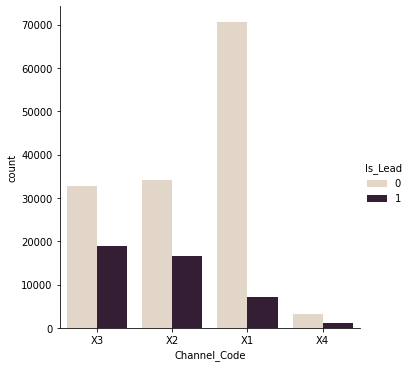

In [ ]:
# sns.catplot(x="Channel_Code", kind="count", hue = "Is_Lead", palette="ch:.25", data=x_train_visual)
# # df['Channel_Code'].plot.kde()

# #Preparing train and test

In [86]:
x_train = process_all(x_train)
# processing x_test
print('X_TRAIN Processed successfully')
x_test_raw = x_test.copy()
x_test_check = x_test_raw.copy()
x_test = process_all(x_test)
print('X_TEST Processed successfully')

Region Code Processed Successfully
Channel Code Processed Successfully
Gender Processed Successfully
Occupation Processed Successfully
Is Active Processed Successfully
transformed successfully
features engineered
X_TRAIN Processed successfully
Region Code Processed Successfully
Channel Code Processed Successfully
Gender Processed Successfully
Occupation Processed Successfully
Is Active Processed Successfully
transformed successfully
features engineered
X_TEST Processed successfully


# Model Fitting

In [87]:
def metrics(Pred, Classifier, X_Test=x_test, labels=y_test):
  # prints different metrics
  accuracy = accuracy_score(y_true=labels, y_pred=Pred)
  roc_auc = roc_auc_score(y_true=labels, y_score=Pred)
  print(f'Accuracy: {accuracy} \n ROC_AUC_Score: {roc_auc}')
  
  plot_confusion_matrix(estimator= Classifier,X=X_Test, y_true=labels, values_format= '.3f')
  
  plot_roc_curve(Classifier, X=X_Test, y=labels)

  return accuracy, roc_auc_score

In [21]:
# %% Implementing Random Forests
clf_rforest = RandomForestClassifier(random_state= 10, max_features="log2", oob_score= True)
clf_rforest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=10, verbose=0,
                       warm_start=False)

In [88]:
x_train

,Channel_Code_proc_0,Channel_Code_proc_1,Channel_Code_proc_2,Channel_Code_proc_3,Gender_proc_0,Gender_proc_1,Occupation_proc_0,Occupation_proc_1,Occupation_proc_2,Occupation_proc_3,Is_Active_proc_0,Is_Active_proc_1,Credit_Product_proc_0,Credit_Product_proc_1,Age_Binned_0,Age_Binned_1,Age_Binned_2,Age_box,Avg_Account_Balance_log,Vintage_max
188708,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,2.382262,13.205711,0.869727
17007,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,2.428043,13.701104,0.798635
109929,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.571627,13.966871,0.847988
81455,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.559092,14.357853,0.261663
77866,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,2.159984,14.214079,0.406457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130365,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,2.531975,14.528371,0.889875
92303,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,2.285033,13.679998,0.389346
6618,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,2.207271,13.986131,0.480377
90430,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,2.428043,14.315680,0.727458


In [89]:
# %%
# getting important features
feature_list = x_train.columns
imp_feature = {}
for feat_name, weight in zip(feature_list, clf_rforest.feature_importances_):
    imp_feature[feat_name] = weight


for key in imp_feature:
    value = round(imp_feature[key],3)*100
    print(f'{key} : {value} %')

Channel_Code_proc_0 : 2.9000000000000004 %
Channel_Code_proc_1 : 0.7000000000000001 %
Channel_Code_proc_2 : 0.8999999999999999 %
Channel_Code_proc_3 : 0.1 %
Gender_proc_0 : 0.4 %
Gender_proc_1 : 0.4 %
Occupation_proc_0 : 0.8 %
Occupation_proc_1 : 0.8999999999999999 %
Occupation_proc_2 : 2.8000000000000003 %
Occupation_proc_3 : 0.5 %
Is_Active_proc_0 : 0.7000000000000001 %
Is_Active_proc_1 : 0.7000000000000001 %
Credit_Product_proc_0 : 0.6 %
Credit_Product_proc_1 : 0.5 %
Age_Binned_0 : 1.3 %
Age_Binned_1 : 1.0 %
Age_Binned_2 : 0.3 %
Age_box : 18.0 %
Avg_Account_Balance_log : 44.4 %
Vintage_max : 22.3 %


In [25]:
y_hat_rforest = clf_rforest.predict(x_test)
y_hat_rf_proba = clf_rforest.predict_proba(x_test)

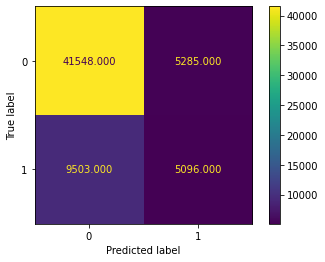

In [30]:
plot_confusion_matrix(clf_rforest,X=x_test, y_true=y_test, values_format= '.3f')
# plot_roc_curve(Classifier, X=X_Test, y=labels)

In [90]:
x_test_check['True'] = y_test
x_test_check['Pred'] = y_hat_rforest

In [91]:
x_test_check.loc[x_test_check['True']!=x_test_check['Pred']]

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,True,Pred
193655,Male,58,RG264,Self_Employed,X2,85,Yes,1407285,No,0,1
195952,Male,67,RG283,Other,X3,38,NaN,1126028,Yes,1,0
9277,Male,75,RG268,Other,X3,86,Yes,361749,No,0,1
218985,Female,60,RG283,Other,X3,98,NaN,1377889,No,0,1
22306,Male,50,RG277,Entrepreneur,X4,13,Yes,862935,No,1,0
...,...,...,...,...,...,...,...,...,...,...,...
96844,Male,54,RG283,Other,X3,75,Yes,786466,No,0,1
210902,Female,39,RG278,Self_Employed,X2,14,No,403810,Yes,1,0
195212,Male,57,RG280,Self_Employed,X2,91,NaN,486678,Yes,1,0
123152,Female,47,RG283,Self_Employed,X2,73,Yes,1275645,Yes,1,0


In [34]:
# threshold = 0.45
# predicted = (y_hat_rf_proba [:,1] >= threshold).astype('int')
# metrics(predicted,clf_rforest)

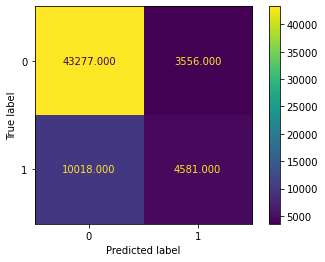

In [ ]:
plot_confusion_matrix(estimator= clf_rforest,X=x_test, y_true=y_test, values_format= '.3f')

In [35]:
roc_auc_score(y_true=y_test, y_score=y_hat_rf_proba[:,1])

0.7303691495757472

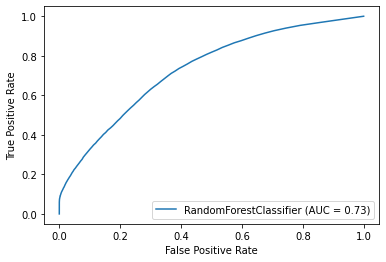

In [36]:
plot_roc_curve(clf_rforest, X=x_test, y=y_test)

##XGBOOST

In [174]:
n_train = len(x_train)-1
train = 1
# (x_train[eval_ind:],y_train[eval_ind:])
eval_ind = int(n_train*train)
eval_set = [(x_train[0:eval_ind], y_train[0:eval_ind]),(x_test, y_test)]

clf_xgb = XGBClassifier(max_depth = 6,
                        n_estimators=100,                        
                        learning_rate = 0.1,
                        gamma = 0.1,
                        random_state = 25)
clf_xgb.fit(x_train,y_train,eval_set= eval_set,eval_metric=['auc','error'])
y_hat_xgb = clf_xgb.predict(x_test)

[0]	validation_0-auc:0.775441	validation_0-error:0.213276	validation_1-auc:0.771636	validation_1-error:0.213488
[1]	validation_0-auc:0.775508	validation_0-error:0.213276	validation_1-auc:0.771687	validation_1-error:0.213488
[2]	validation_0-auc:0.7755	validation_0-error:0.213276	validation_1-auc:0.771685	validation_1-error:0.213488
[3]	validation_0-auc:0.775506	validation_0-error:0.213287	validation_1-auc:0.771703	validation_1-error:0.213456
[4]	validation_0-auc:0.775505	validation_0-error:0.213287	validation_1-auc:0.771702	validation_1-error:0.213456
[5]	validation_0-auc:0.775673	validation_0-error:0.213276	validation_1-auc:0.771831	validation_1-error:0.213456
[6]	validation_0-auc:0.776567	validation_0-error:0.210964	validation_1-auc:0.771898	validation_1-error:0.211632
[7]	validation_0-auc:0.776645	validation_0-error:0.213938	validation_1-auc:0.771852	validation_1-error:0.213846
[8]	validation_0-auc:0.776768	validation_0-error:0.213943	validation_1-auc:0.771698	validation_1-error:0.2

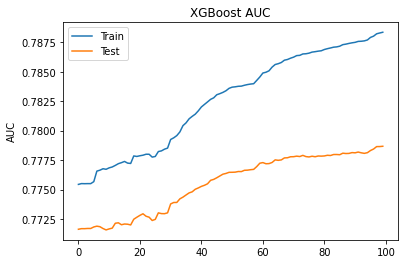

In [175]:
results = clf_xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()

ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

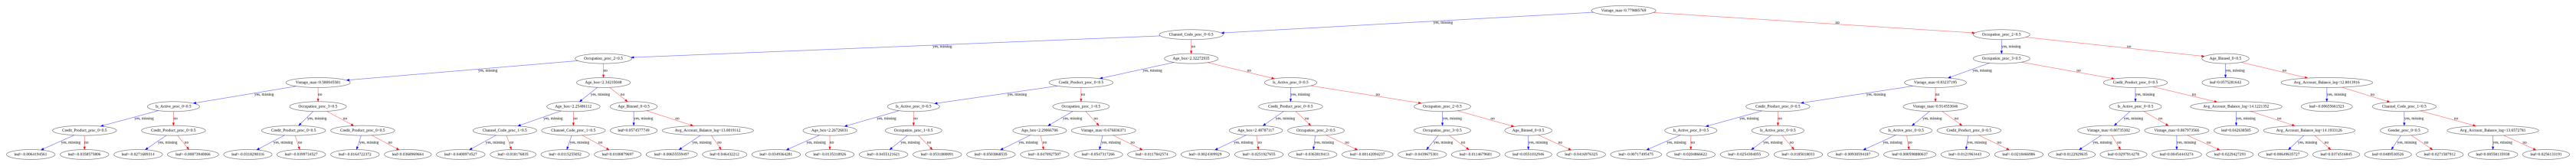

In [185]:
fig, ax = plt.subplots(figsize=(60, 30))
plot_tree(clf_xgb, num_trees=1, ax = ax)
plt.savefig('1.png')

Accuracy: 0.7900931110821722 
 ROC_AUC_Score: 0.5932005953878731


(0.7900931110821722, <function sklearn.metrics._ranking.roc_auc_score>)

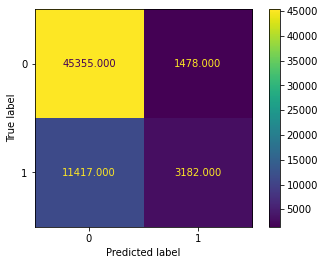

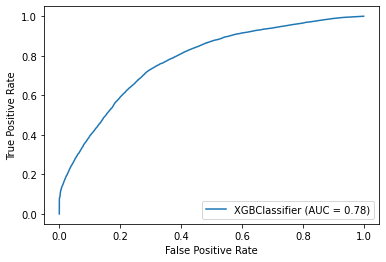

In [176]:
metrics(y_hat_xgb,clf_xgb)

In [110]:
clf_xgb.feature_importances_

array([0.32828802, 0.02816099, 0.00607271, 0.00418621, 0.00653521,
       0.        , 0.05087006, 0.01950103, 0.119385  , 0.06145964,
       0.04347147, 0.        , 0.02252308, 0.        , 0.01970419,
       0.05902859, 0.        , 0.11538931, 0.0048695 , 0.1105551 ],
      dtype=float32)

In [ ]:
gender_dic = {'Male': 0,
              'Female': 1}

is_active_dic = {'Yes': 1,
                 'No': 0}

occupation_dic = {'Self_Employed': 1,
                    'Other': 2,
                    'Salaried': 3,
                    'Entrepreneur': 4}


In [177]:
feature_list = x_train.columns
imp_feature = {}
for feat_name, weight in zip(feature_list, clf_xgb.feature_importances_):
    imp_feature[feat_name] = weight


for key in imp_feature:
    value = round(imp_feature[key],3)*100
    print(f'{key} : {value} %')

Channel_Code_proc_0 : 45.100000500679016 %
Channel_Code_proc_1 : 0.800000037997961 %
Channel_Code_proc_2 : 0.8999999612569809 %
Channel_Code_proc_3 : 1.4000000432133675 %
Gender_proc_0 : 0.4000000189989805 %
Gender_proc_1 : 0.0 %
Occupation_proc_0 : 2.800000086426735 %
Occupation_proc_1 : 1.899999938905239 %
Occupation_proc_2 : 14.900000393390656 %
Occupation_proc_3 : 4.1999999433755875 %
Is_Active_proc_0 : 2.199999988079071 %
Is_Active_proc_1 : 0.0 %
Credit_Product_proc_0 : 1.899999938905239 %
Credit_Product_proc_1 : 0.0 %
Age_Binned_0 : 1.0999999940395355 %
Age_Binned_1 : 1.2000000104308128 %
Age_Binned_2 : 4.399999976158142 %
Age_box : 7.100000232458115 %
Avg_Account_Balance_log : 0.3000000026077032 %
Vintage_max : 9.399999678134918 %


# Debugg

In [96]:
x_test_check = process(x_test_check)
x_test_check = transform(x_test_check)
x_test

Region Code Processed Successfully
Channel Code Processed Successfully
Gender Processed Successfully
Occupation Processed Successfully
Is Active Processed Successfully


,Channel_Code_proc_0,Channel_Code_proc_1,Channel_Code_proc_2,Channel_Code_proc_3,Gender_proc_0,Gender_proc_1,Occupation_proc_0,Occupation_proc_1,Occupation_proc_2,Occupation_proc_3,Is_Active_proc_0,Is_Active_proc_1,Credit_Product_proc_0,Credit_Product_proc_1,Age_Binned_0,Age_Binned_1,Age_Binned_2,Age_box,Avg_Account_Balance_log,Vintage_max
171739,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.274161,14.028877,0.558235
98848,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,2.259858,13.427141,0.259535
184607,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.259858,12.747213,0.386691
61725,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,2.244923,13.775419,0.284462
48107,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,2.522875,14.608174,0.694617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236899,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,2.568940,14.465202,0.882107
65610,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.244923,13.866489,0.232581
42881,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.229302,12.866498,0.368664
199081,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,2.418653,13.354089,0.792194


In [129]:
# x_test_check['Channel_Code'].loc[x_test_check['Channel_Code']=='X1'].count()

26024

In [124]:
# x_test_check['Channel_Code_proc_1'].loc[x_test_check['Channel_Code_proc_1']==1].count()

16931

In [130]:
x_test_check['Pred'] = y_hat_xgb

In [131]:
check_df = x_test_check.loc[((x_test_check['True']==1) & (x_test_check['Pred'] == 0))]
check_df

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,True,Pred,Region_Code_proc,Channel_Code_proc,Channel_Code_proc_0,Channel_Code_proc_1,Channel_Code_proc_2,Channel_Code_proc_3,Gender_proc,Gender_proc_0,Gender_proc_1,Occupation_proc,Occupation_proc_0,Occupation_proc_1,Occupation_proc_2,Occupation_proc_3,Is_Active_proc,Is_Active_proc_0,Is_Active_proc_1,Credit_Product_proc,Credit_Product_proc_0,Credit_Product_proc_1,Age_Binned,Age_Binned_0,Age_Binned_1,Age_Binned_2,Age_box,Avg_Account_Balance_log,Vintage_box,Vintage_max
195952,Male,67,RG283,Other,X3,38,No,1126028,Yes,1,0,283,3,0.0,0.0,1.0,0.0,0,1.0,0.0,2,0.0,1.0,0.0,0.0,1,0.0,1.0,0,1.0,0.0,60+,0.0,0.0,1.0,2.579352,13.934207,3.085070,0.605134
124385,Male,33,RG268,Salaried,X3,45,No,844031,Yes,1,0,268,3,0.0,0.0,1.0,0.0,0,1.0,0.0,3,0.0,0.0,1.0,0.0,1,0.0,1.0,0,1.0,0.0,20-40,1.0,0.0,0.0,2.313715,13.645945,3.204582,0.660533
113088,Male,48,RG283,Entrepreneur,X2,55,No,1395582,Yes,1,0,283,2,0.0,1.0,0.0,0.0,0,1.0,0.0,4,0.0,0.0,0.0,1.0,1,0.0,1.0,0,1.0,0.0,40-60,0.0,1.0,0.0,2.460223,14.148822,3.344004,0.725162
22306,Male,50,RG277,Entrepreneur,X4,13,Yes,862935,No,1,0,277,4,0.0,0.0,0.0,1.0,0,1.0,0.0,4,0.0,0.0,0.0,1.0,0,1.0,0.0,1,0.0,1.0,40-60,0.0,1.0,0.0,2.475355,13.668095,2.281375,0.232581
178812,Male,55,RG251,Self_Employed,X3,104,No,552930,No,1,0,251,3,0.0,0.0,1.0,0.0,0,1.0,0.0,1,1.0,0.0,0.0,0.0,0,1.0,0.0,0,1.0,0.0,40-60,0.0,1.0,0.0,2.510078,13.222987,3.769727,0.922507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128193,Female,31,RG264,Salaried,X1,31,Yes,536429,Yes,1,0,264,1,1.0,0.0,0.0,0.0,1,0.0,1.0,3,0.0,0.0,1.0,0.0,1,0.0,1.0,1,0.0,1.0,20-40,1.0,0.0,0.0,2.287878,13.192689,2.938633,0.537253
230906,Male,41,RG283,Self_Employed,X3,73,No,751453,No,1,0,283,3,0.0,0.0,1.0,0.0,0,1.0,0.0,1,1.0,0.0,0.0,0.0,0,1.0,0.0,0,1.0,0.0,40-60,0.0,1.0,0.0,2.400290,13.529764,3.536331,0.814316
210902,Female,39,RG278,Self_Employed,X2,14,No,403810,Yes,1,0,278,2,0.0,1.0,0.0,0.0,1,0.0,1.0,1,1.0,0.0,0.0,0.0,1,0.0,1.0,0,1.0,0.0,20-40,1.0,0.0,0.0,2.380766,12.908700,2.339523,0.259535
195212,Male,57,RG280,Self_Employed,X2,91,No,486678,Yes,1,0,280,2,0.0,1.0,0.0,0.0,0,1.0,0.0,1,1.0,0.0,0.0,0.0,1,0.0,1.0,0,1.0,0.0,40-60,0.0,1.0,0.0,2.522875,13.095358,3.682574,0.882107


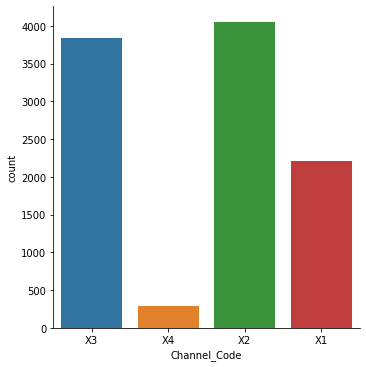

In [112]:
sns.catplot(x='Channel_Code',kind = 'count', data=check_df)

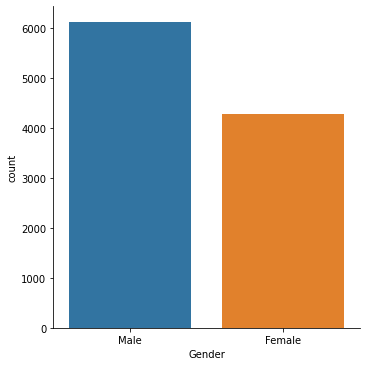

In [113]:
sns.catplot(x='Gender',kind = 'count', data=check_df)

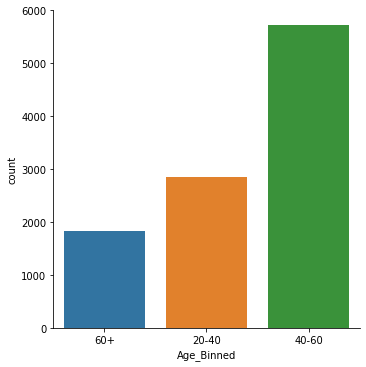

In [114]:
sns.catplot(x='Age_Binned', kind = 'count', data = check_df)

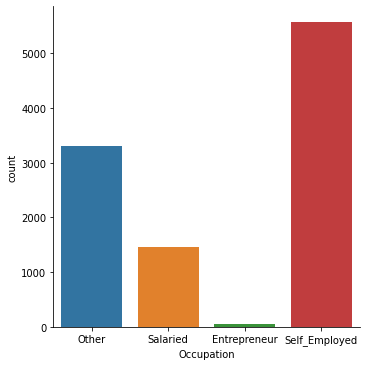

In [115]:
sns.catplot(x='Occupation',kind = 'count', data=check_df)

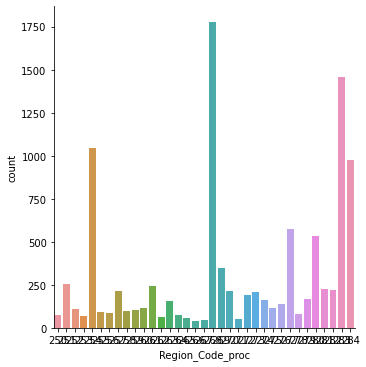

In [116]:
# fig = plt.figure(figsize=(30,30))
sns.catplot(x='Region_Code_proc',kind = 'count', data=check_df)

In [117]:
# calculate fpr and tpr
fp = x_test_check['Pred'].loc[((x_test_check['True']==0) & (x_test_check['Pred']==1))].count()
fpn = x_test_check['Pred'].loc[((x_test_check['True']==0))].count()

tp = x_test_check['Pred'].loc[((x_test_check['True']==1) & (x_test_check['Pred']==1))].count()
tpn = x_test_check['Pred'].loc[((x_test_check['True']==1))].count()

fpr = fp/fpn
tpr = tp/tpn

print(f'TP:{tp}, TPN:{tpn}',
      f'\n FP:{fp},FPN:{fpn}')
print(f'tpr: {tpr}, fpr:{fpr}')

TP:4202, TPN:14599 
 FP:2729,FPN:46833
tpr: 0.28782793342009727, fpr:0.05827087737279269
